In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
from sklearn.metrics import plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

### Data Management

In [2]:
# Data Extraction
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date", inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634


In [3]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [4]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-28,-0.021487,-0.018129,0.008047,28814.900391,-0.029042,0.006544,0.009117,32.894788,37.238957,1.027560,...,5,-0.298233,0.056286,-0.021856,0.036020,0.949541,-0.009984,0.055632,0.977232,0.0
2022-05-29,0.013879,0.023707,0.010035,29445.957031,-0.490594,0.021900,0.022777,33.634047,40.613855,1.090628,...,6,-0.247068,0.055605,0.006544,0.009117,1.027560,-0.021856,0.036020,0.949541,1.0
2022-05-30,0.014593,0.083111,0.016035,31726.390625,1.170788,0.077445,0.090298,36.313300,50.890862,1.253042,...,0,-0.146443,0.057666,0.021900,0.022777,1.090628,0.006544,0.009117,1.027560,0.0
2022-05-31,0.077454,0.009397,0.067657,31792.310547,-0.146132,0.002078,0.030803,36.391116,51.154006,1.005171,...,1,-0.164364,0.057768,0.077445,0.090298,1.253042,0.021900,0.022777,1.090628,1.0
2022-06-01,0.002165,-0.009072,-0.057040,29799.080078,0.226536,-0.062695,0.083239,34.041939,43.554422,0.851437,...,2,-0.228625,0.059741,0.002078,0.030803,1.005171,0.077445,0.090298,1.253042,0.0


### Train Test Split

In [5]:
# Feature Selection
df_tts = df.copy()
df_tts = df_tts[["Returns", "Range", "RSI", "RSI_Ret", "Returns_T1", "RSI_Ret_T1", "TARGET"]]

In [6]:
# Split into X and Y Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [7]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (1363, 6)
Shape of y_train:  (1363,)
Shape of X_test:  (585, 6)
Shape of y_test:  (585,)
Size Matches:  True


### Build Model

In [8]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [9]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [10]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [11]:
# Hyperparams: ne: 80, lr: 0.01 md: 3 gm: 6
ne = 150
lr = 0.01
md = 2
gm = 6

In [12]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [13]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.fit(X_train, y_train, eval_metric=eval_metric_list, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=6, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Make Predictions

In [14]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [0 0 0 0 0 0 0 0 0 1]
Preds Probabilities Training Data: 
 [[0.67917484 0.32082516]
 [0.6628872  0.3371128 ]
 [0.625505   0.37449503]]


In [15]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [1 1 1 1 1 1 1 1 0 1]
Preds Probabilities Training Data: 
 [[0.39635187 0.6036481 ]
 [0.39635187 0.6036481 ]
 [0.3615198  0.6384802 ]]


In [16]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [17]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

### Evaluation Metrics  - Loss and Overfitting

In [18]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

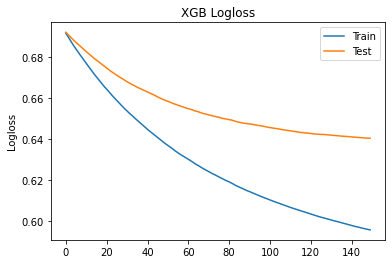

In [19]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

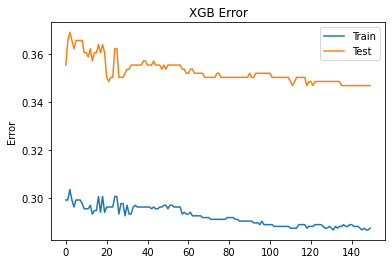

In [20]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

### Evaluation Metrics - ROC Curve

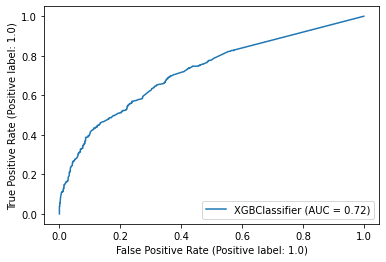

In [21]:
# Plot Training ROC Curve
plot_roc_curve(classifier, X_train, y_train)

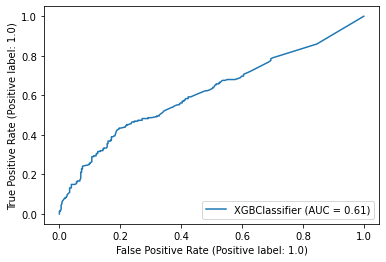

In [22]:
# Plot Test ROC Curve
plot_roc_curve(classifier, X_test, y_test)

### Performance Evaluation Comparison

In [23]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [24]:
# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

/Users/shaunmcdonogh/opt/miniconda3/envs/MLTRADE/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/shaunmcdonogh/opt/miniconda3/envs/MLTRADE/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/shaunmcdonogh/opt/miniconda3/envs/MLTRADE/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/shaunmcdonogh/opt/miniconda3/envs/MLTRADE/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

In [25]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.69
Std Dev K-Fold 0.03
Precision Score 0 0.711
Precision Score 1 0.718
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.62
Std Dev K-Fold 0.1
Precision Score 0 0.659
Precision Score 1 0.624



### Evaluation Metrics - Summary Report

In [26]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.71      0.93      0.80       872
         1.0       0.72      0.33      0.45       491

    accuracy                           0.71      1363
   macro avg       0.71      0.63      0.63      1363
weighted avg       0.71      0.71      0.68      1363



In [27]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.66      0.89      0.76       357
         1.0       0.62      0.28      0.38       228

    accuracy                           0.65       585
   macro avg       0.64      0.58      0.57       585
weighted avg       0.65      0.65      0.61       585



### Performance Evaluation - Confusion Matrix

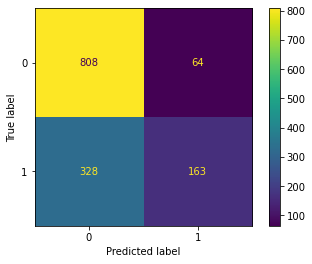

In [28]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

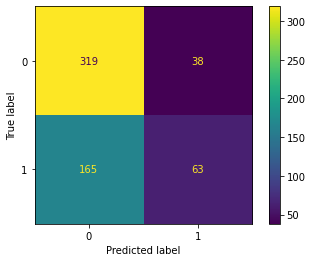

In [29]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

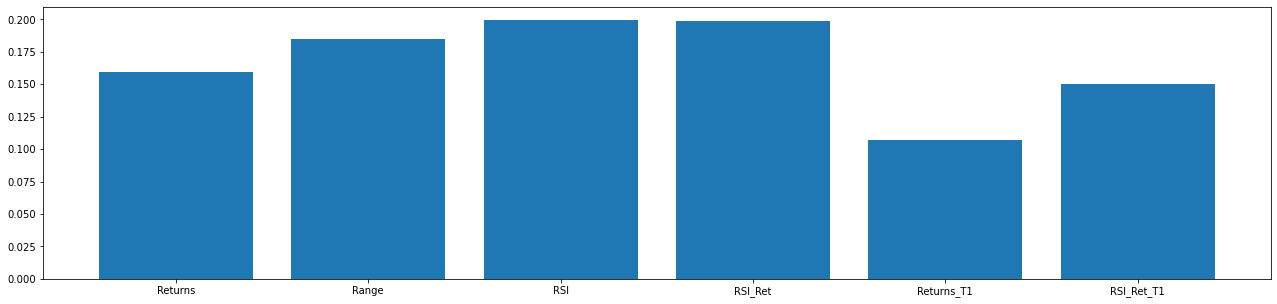

In [30]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

### XGBOOST TREE

<AxesSubplot:>

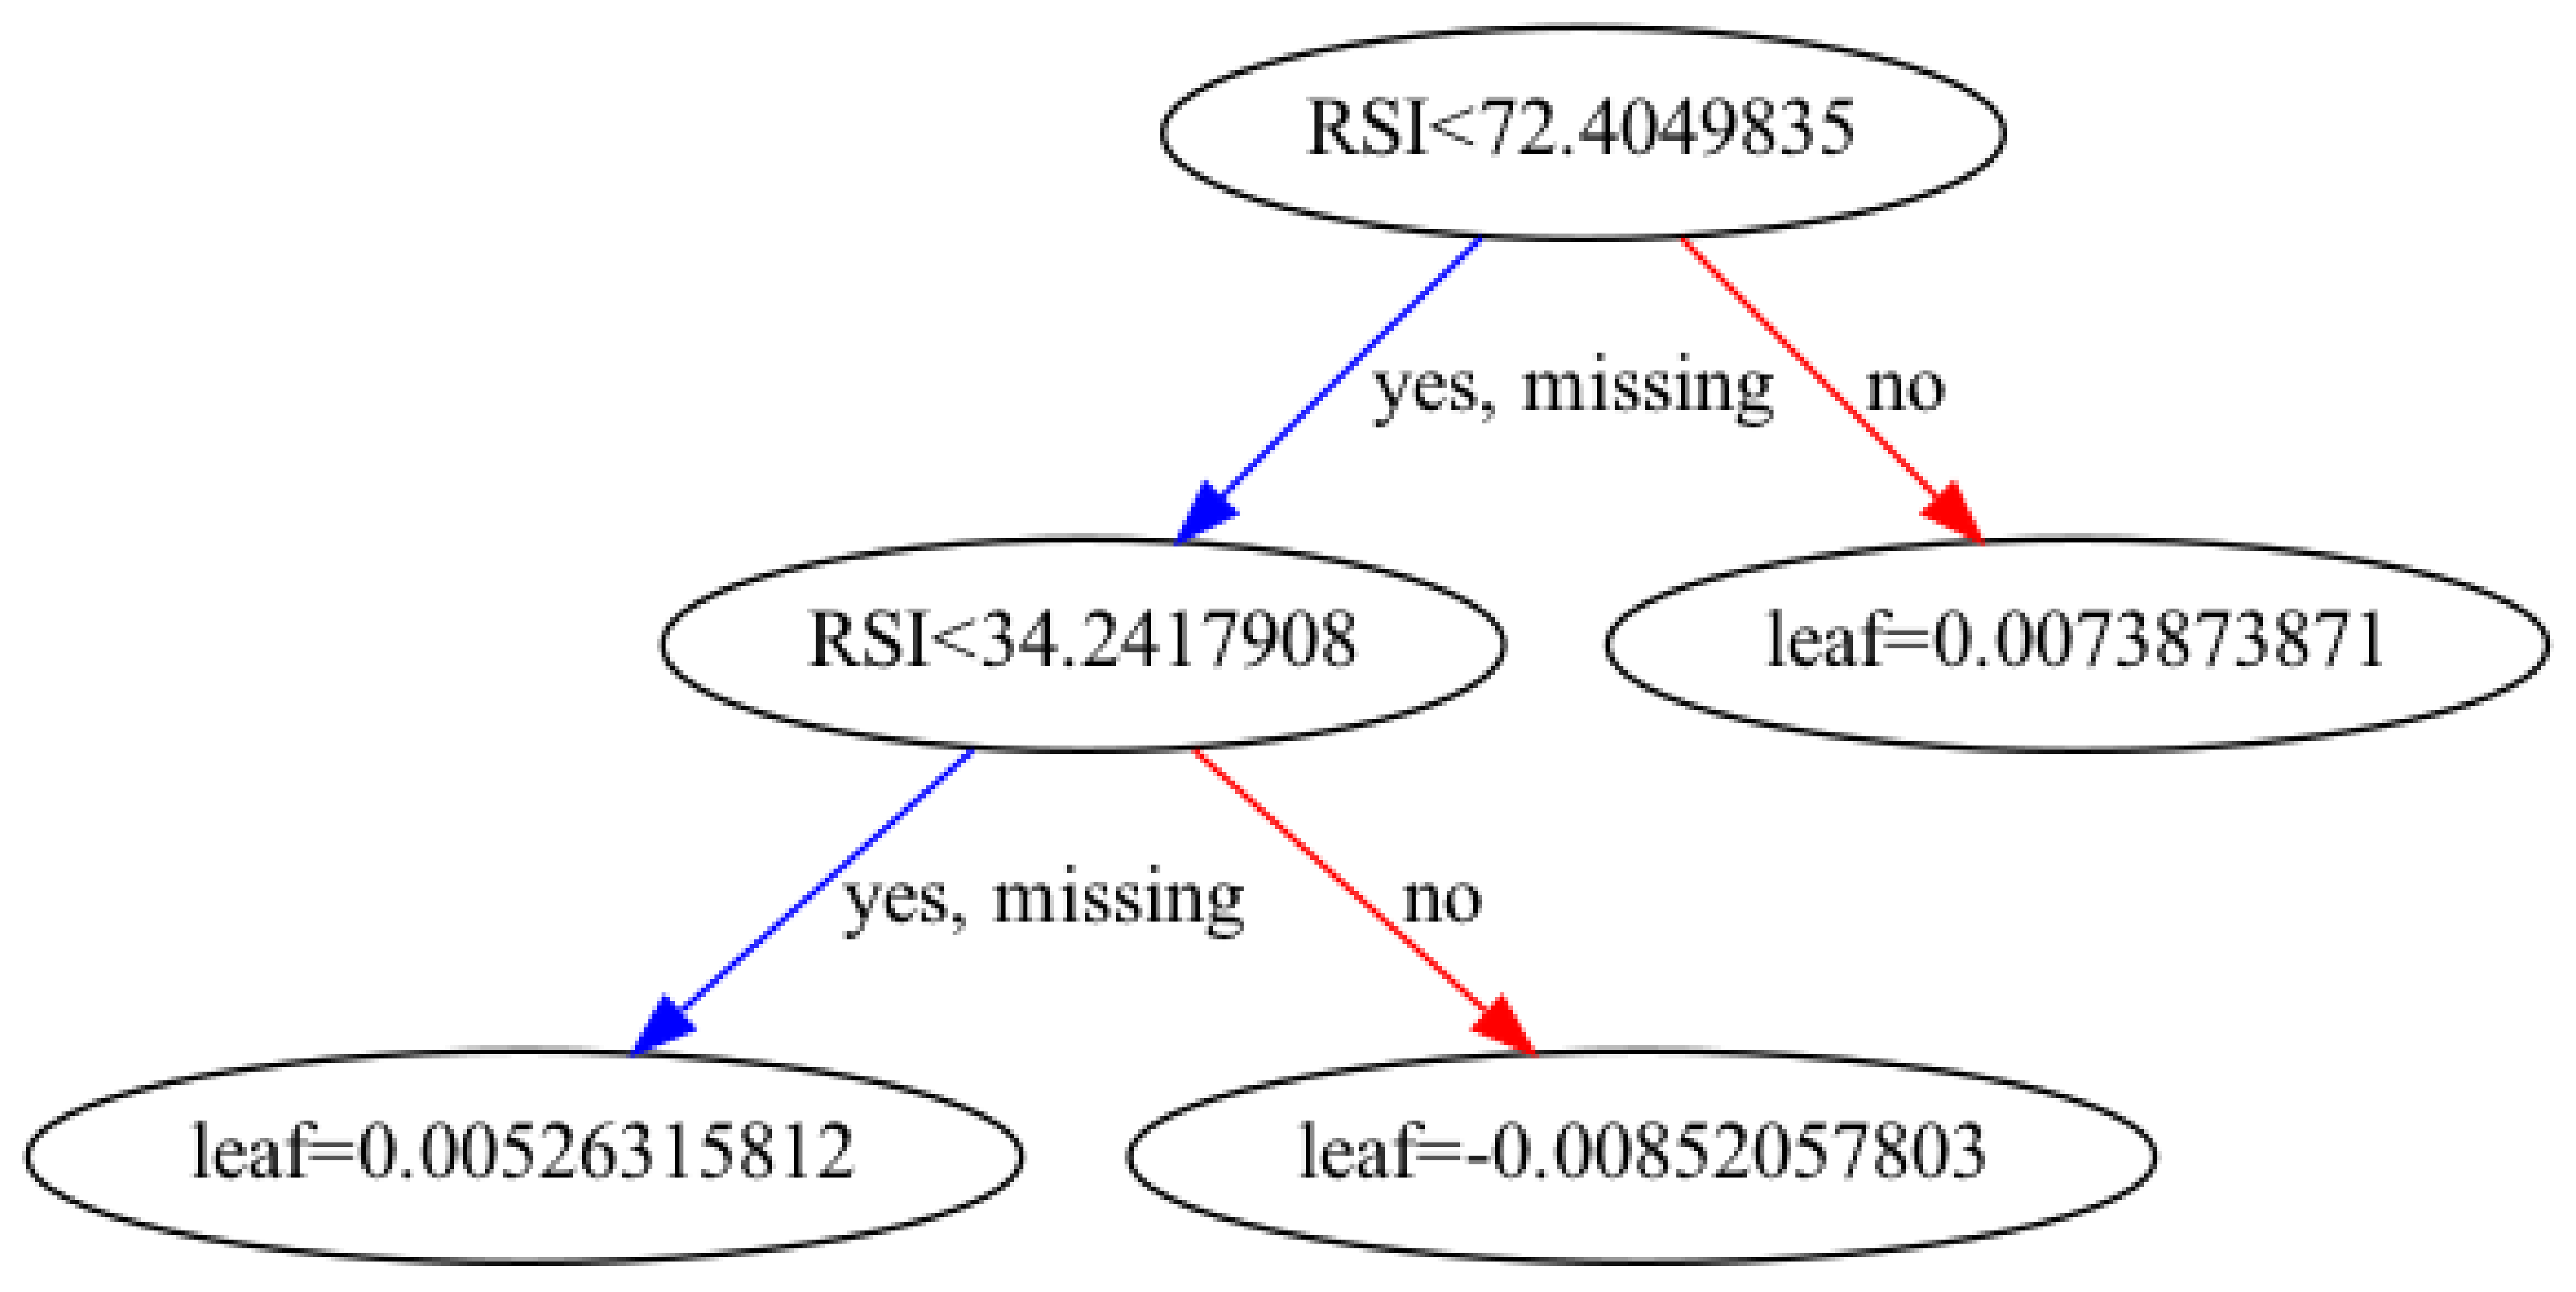

In [31]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)

### Conclusion

We feel that it is possible using Machine Learning, that we can forecast with better than 50/50 odds, whether the Range (our interpretation of volatility) for Bitcoin, can be predicted ahead of of time by at least 1 day into the future. This information could be valuable for MOVE based contracts trading.